In [26]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-a6p821x1
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-a6p821x1
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [27]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

fatal: destination path 'Person-Re-Id-Dataset' already exists and is not an empty directory.


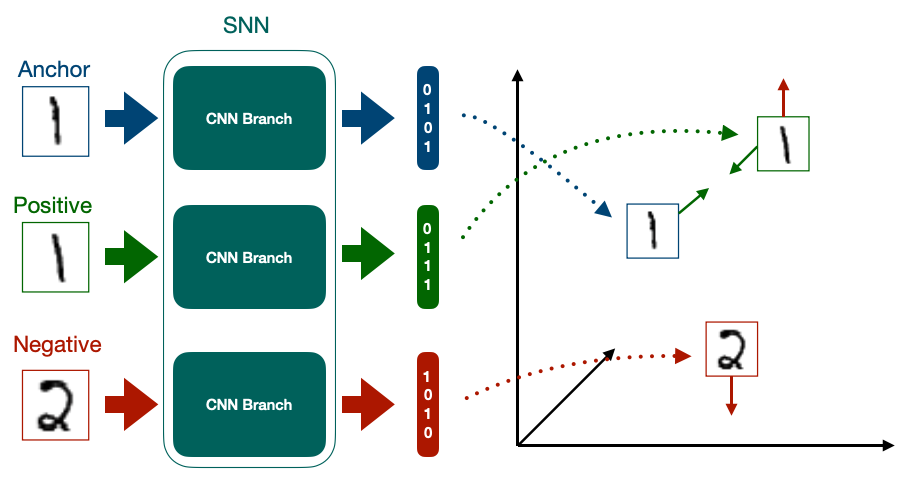

# Imports

In [28]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [30]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.01
EPOCHS=15

DEVICE = 'cuda'

In [31]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [32]:
row = df.iloc[4]
A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)


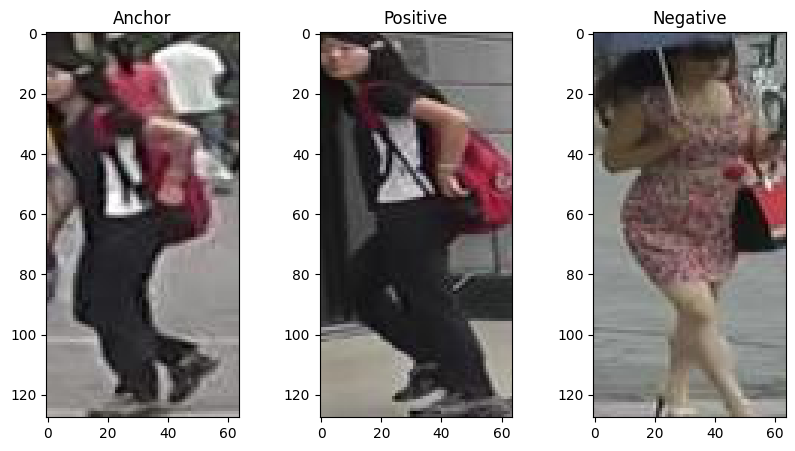

In [33]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [34]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Create APN Dataset

In [35]:
class APN_Dataset(Dataset):
  def __init__(self, df):
    self.df = df
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    A_img = torch.from_numpy(A_img).permute(2,0,1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2,0,1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2,0,1) / 255.0

    return A_img, P_img, N_img

In [36]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)
print(f"Size of Trainset= {len(trainset)}")
print(f"Size of Validset= {len(validset)}")

Size of Trainset= 3200
Size of Validset= 800


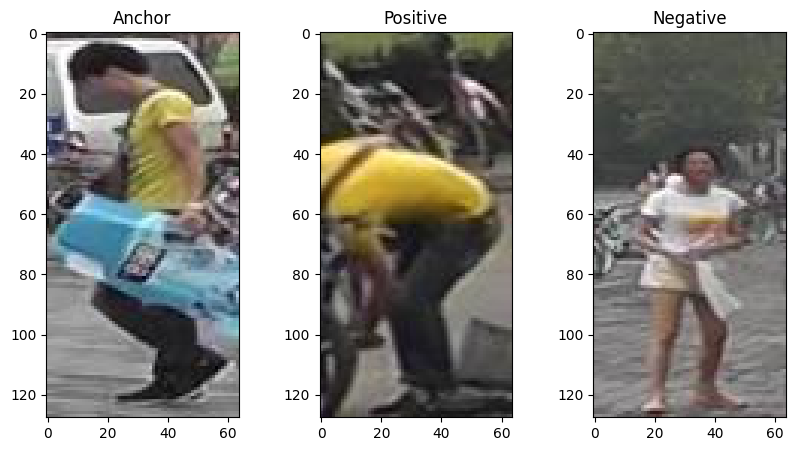

In [37]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [38]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE, shuffle=True)

In [39]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [40]:
for A,P,N in trainloader:
  break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [41]:
class APN_model(nn.Module):
  def __init__ (self, emb_size=512):
    super(APN_model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained= True)
    self.efficientnet.classifier= nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)

    return embeddings



In [42]:
model = APN_model()
model.to(DEVICE)

APN_model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [43]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train() # it turns on the dropout

  total_loss=0.0

  for A,P,N in tqdm(dataloader):
    A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss = loss.item()

    return total_loss/len(dataloader)


In [44]:
def eval_fn(model, dataloader, criterion):

  model.eval() # it turns off the dropout

  total_loss=0.0

  with torch.no_grad():
    for A,P,N in tqdm(dataloader):
      A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)

      total_loss = loss.item()

      return total_loss/len(dataloader)

In [45]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [46]:
best_valid_loss = np.inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("SAVED WEights Success")

  print(f"Epochs: {i + 1} train_loss: {train_loss} valid_loss: {valid_loss}")




  0%|          | 0/25 [00:00<?, ?it/s]


SAVED WEights Success
Epochs: 1 train_loss: 0.008761330842971801 valid_loss: 0.03248860836029053


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 2 train_loss: 0.017900619506835937 valid_loss: 0.07823193073272705


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 3 train_loss: 0.02687507152557373 valid_loss: 0.43749649047851563


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 4 train_loss: 0.04713522434234619 valid_loss: 0.32952537536621096


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 5 train_loss: 0.09750339508056641 valid_loss: 2.1223881530761717


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 6 train_loss: 0.0758647632598877 valid_loss: 29.04576904296875


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 7 train_loss: 0.041162548065185545 valid_loss: 19.028427734375


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 8 train_loss: 0.035107343196868895 valid_loss: 28.41129150390625


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 9 train_loss: 0.028408284187316894 valid_loss: 86.2358984375


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 10 train_loss: 0.06878440380096436 valid_loss: 33.32795654296875


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 11 train_loss: 0.05134594917297363 valid_loss: 25.680009765625


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 12 train_loss: 0.04116679191589356 valid_loss: 14.21574462890625


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 13 train_loss: 0.03955063343048096 valid_loss: 10.71042236328125


  0%|          | 0/25 [00:00<?, ?it/s]


Epochs: 14 train_loss: 0.03715691566467285 valid_loss: 4.227940979003907


  0%|          | 0/25 [00:00<?, ?it/s]

Epochs: 15 train_loss: 0.03742813110351562 valid_loss: 2.260542297363281


# Get Anchor Embeddings

In [48]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()

  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2,0,1)/255.0
      A = A.to(DEVICE)

      A_enc = model(A.unsqueeze(0))

      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)

    df_enc = pd.concat([anc_img_names, encodings], axis=1)

    return df_enc

In [49]:
model.load_state_dict(torch.load("best_model.pt"))

df_enc = get_encoding_csv(model, df["Anchor"])

100%|██████████| 4000/4000 [00:43<00:00, 91.63it/s]


In [50]:
df_enc.to_csv('database.csv', index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.139682,0.134074,0.380445,0.155884,-0.163717,-0.411278,0.112791,0.456066,0.093919,...,-0.229513,0.044342,0.300696,0.517057,0.217887,0.384496,-0.196185,0.462664,0.521765,-0.297454
1,1420_c3s3_061978_03.jpg,-0.399853,0.472830,-0.355019,0.055476,-0.268167,-0.180744,0.094234,-0.055856,-0.232068,...,-0.186770,0.551299,0.345340,0.345498,0.104550,0.142472,-0.340955,0.228939,0.198204,-0.136379
2,1420_c5s3_062565_05.jpg,-0.210160,0.375819,-0.017612,0.329243,-0.438205,0.136336,-0.793857,0.711061,-0.451949,...,0.292157,0.376692,-0.160330,0.458325,0.261085,0.270731,0.113658,0.228757,0.088924,-0.277670
3,1420_c6s3_085592_04.jpg,0.080179,0.284752,-0.168820,0.153007,-0.345612,0.092870,0.294870,0.328432,-0.204927,...,-0.228159,0.132114,-0.482890,0.392963,-0.242371,0.188786,0.302992,0.061972,-0.186141,-0.074328
4,0663_c5s3_085987_03.jpg,-0.190166,0.324452,-0.176718,0.115723,-0.124369,0.028761,0.022092,0.339300,0.387826,...,-0.416107,0.246544,-0.567279,0.374808,0.203576,-0.095104,-0.122364,0.489201,-0.653066,0.676072


# Inference

In [51]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [53]:
idx =0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)

img = torch.from_numpy(img).permute(2, 0, 1)/255.0

model.eval()

with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()


In [55]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [56]:
distance = []

for ii in range(anc_enc_arr.shape[0]):

  dist = euclidean_dist(img_enc, anc_enc_arr[i: i+1, :])

  distance = np.append(distance, dist)

In [58]:
closest_idx = np.argsort(distance)
print(closest_idx)

[   0 2658 2659 ... 1341 1328 3999]


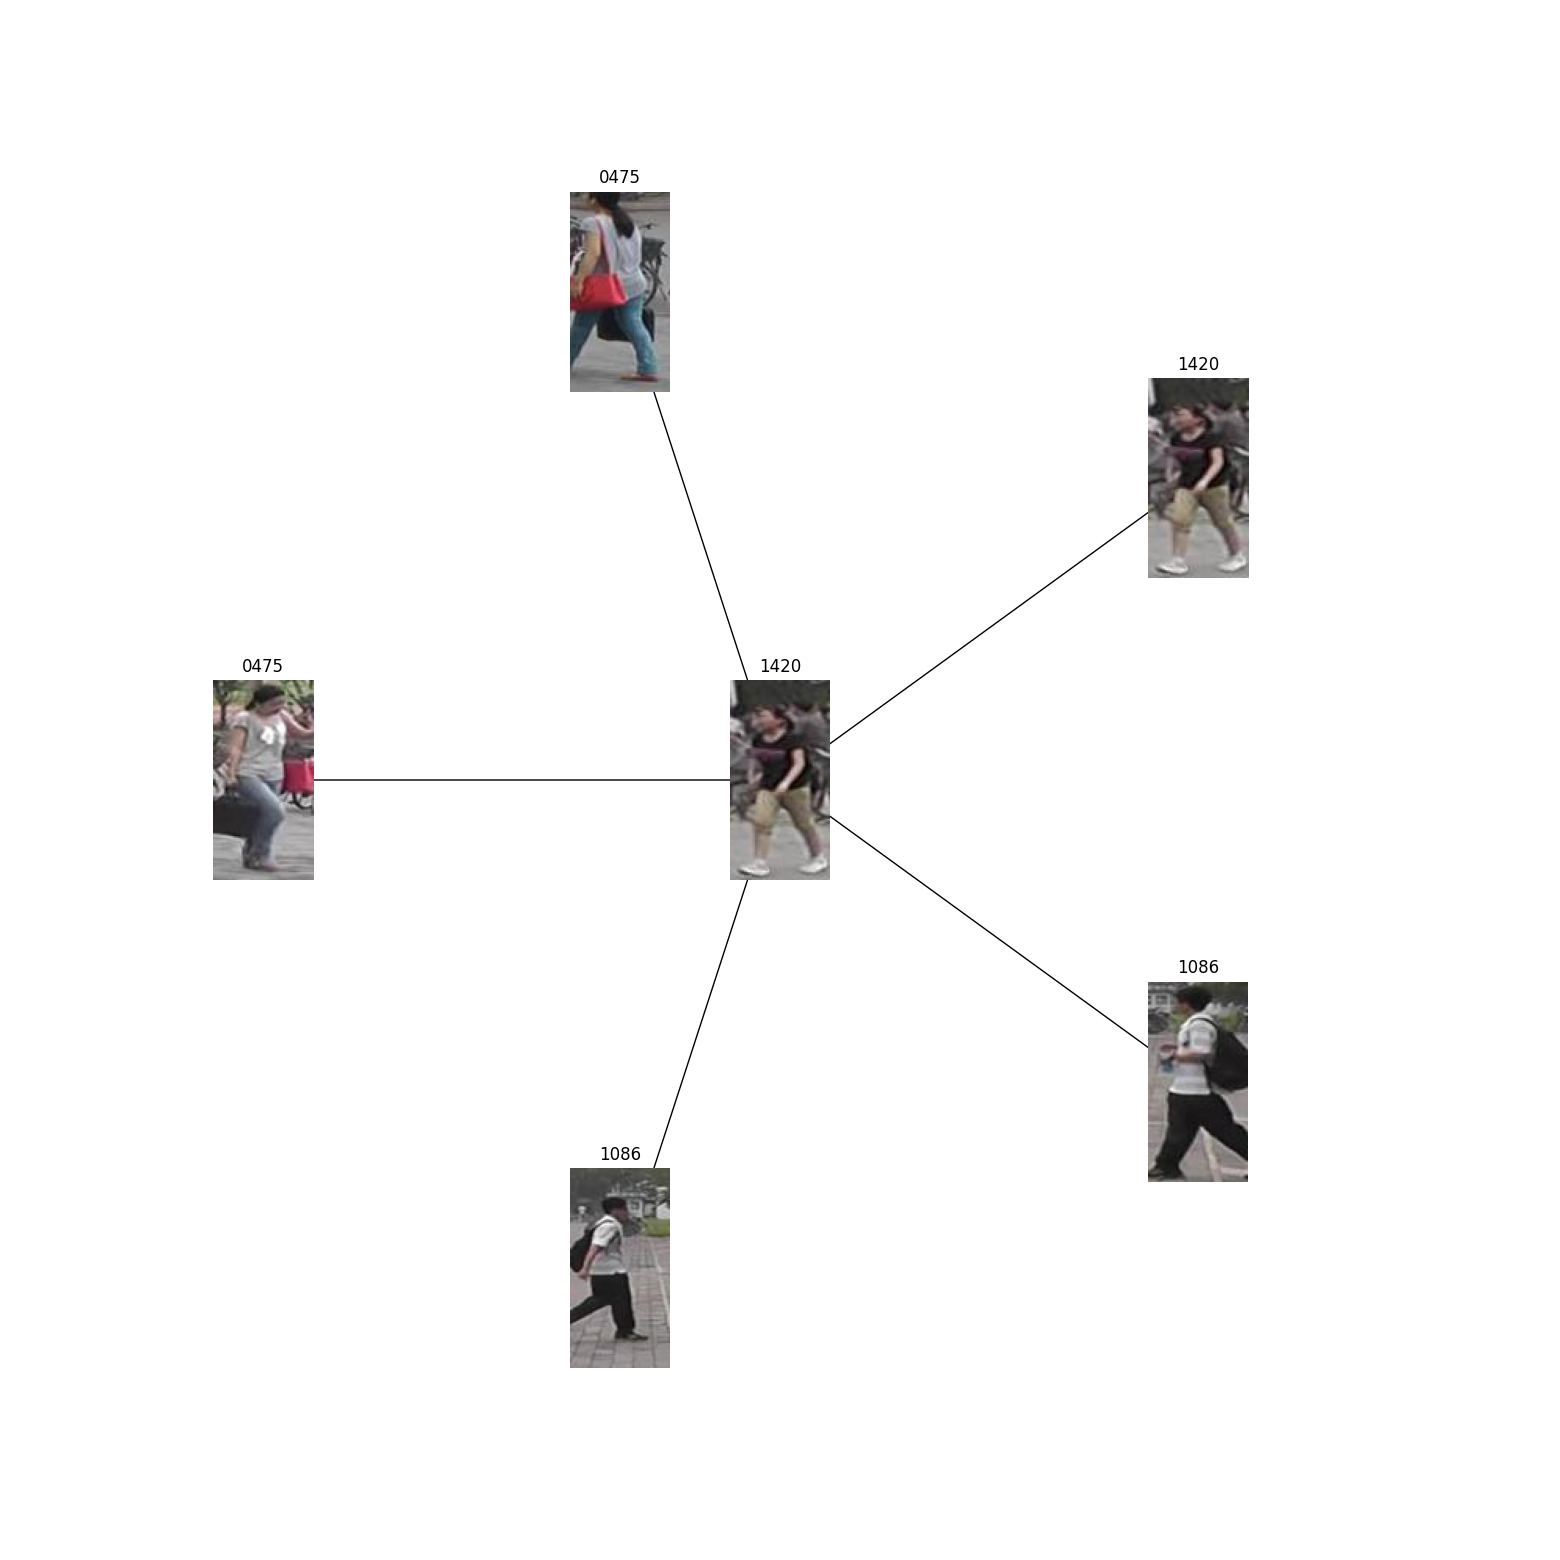

In [59]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);